## Import Modules

In [7]:
#standard modules
import os
import glob

#import mdanalyis modules and packages
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align, distances

#matplotlib
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl

#numpy
import numpy as np

#pandas
import pandas as pd

#nglview
import nglview

#seaborn
import seaborn as sns

#scipy
from scipy.stats import gaussian_kde

## Define functions

In [6]:
def make_universe(path,replica):
    
    #obtain trajectory and topology from file, create a universe
    if replica == 0:
        topology = glob.glob(os.path.join(path,'*.pdb'))
        u = mda.Universe(topology[0])
        
    
    else:
        topology = glob.glob(os.path.join(path,'*.prmtop'))
        trajectory = glob.glob(os.path.join(path, '*{rep}.nc'.format(rep=replica))) 
        u = mda.Universe(topology[0], trajectory[0])
        
    return u

In [7]:
def get_b(a):
        return a + 306

In [8]:
#create string for selecting atoms. Region can be a range of residues or a specific site defined by different residues
def create_selection(selection,region,state):
    
    #Dictionary with selections
    selection_ranges = {'protomer':[1,306],
                    'nterm':[1,14],
                    'domain1':[8,101],
                    'lid':[40,55],
                    'domain2':[102,184],
                    'idl':[185,200],
                    'domain3':[201,303],
                    'cterm':[290,306],
                    'oxyloop':[131,146],
                   'oxyhole':[142,145],
                   'interface_1':[1,14],
                   'interface_2':[109,172],
                   'interface_3':[290,306],
                       'global':[1,612]}

    selection_sites = {'s1_pocket':[140,141,142,163,166,172],
                 's1p_pocket':[24,25],
                 's2_pocket':[41,49,54,165,187],
                 's4_pocket':[165,167,192],
                 'active_site':[41,145],
                 'interface':[1,4,10,12,14,139,166,290,299],
                      'active':[41,49,140,145,163,166,172]}
    
    #Function to convert from chain A to chain B
    def get_b(a):
        return a + 306
    
    #Function to make atom selection of alpha carbons from ranges
    def make_range_selection(start,stop):  
            return f"resid {start}-{stop} and name CA"
        
    #Make selection string from selection
    def make_site_selection(sites):
        selection_string = ''
        for site in sites:
            selection_string += str(site) + ' '

        return 'resid '+ selection_string + 'and name CA'
    
    #create atom selection syntax expression given a range or selection
    if region == 'range':
        
        #define selection in chain A
        range_a = selection_ranges[selection]
        sel_a = make_range_selection(range_a[0],range_a[1])

        #define selection in chain B
        range_b = []
        for sel in selection_ranges[selection]:
            range_b.append(get_b(sel))
        sel_b = make_range_selection(range_b[0],range_b[1])

    elif region == 'site':
        
        #define selection in chain A
        sel_a = make_site_selection(selection_sites[selection])

        #define selection in chain B
        range_b = []
        for sel in selection_sites[selection]:
            range_b.append(get_b(sel))
        sel_b = make_site_selection(range_b)
        
    if state == 'monomer':
        #returns expression for chain A
        return sel_a
    
    elif state == 'dimer':
        #returns expression for chain A and chain B
        return sel_b

In [9]:
#Calculate rmsd for a given replica 
def calc_rmsd(rep,ref,sel):
    R = mda.analysis.rms.RMSD(rep,ref,select='backbone',groupselections=[sel])
    R.run(start=0,stop=1000)
    #with open('{}_rmsd_all.npy'.format(selection),'wb') as f:
        #np.save(f,R.rmsd)
    #print("Finished")
    return R.rmsd

In [10]:
def get_mean_rmsd(rmsd1,rmsd2,rmsd3):
    rmsd = [rmsd1[:,3],rmsd2[:,3],rmsd3[:,3]]
    rmsd_mean = np.mean(rmsd)
    return rmsd_mean

In [11]:
def get_running_mean(rmsd_list):
        stacked_arrays = np.stack((rmsd_list[0], rmsd_list[1], rmsd_list[2]), axis =-1)
        average = np.mean(stacked_arrays, axis=-1)
        return average

In [12]:
def calc_rmsf(rep,ref,sel):
    
    #generate average structure to use as reference
    average = align.AverageStructure(rep,ref,select='backbone and name CA',ref_frame=0).run()
    print(average.results.universe)

    #align trajectory to reference
    aligner = align.AlignTraj(rep,ref,select='backbone and name CA',in_memory=True).run()
    
    #calculate RMSF
    c_alphas = rep.select_atoms(sel)
    R = rms.RMSF(c_alphas).run()
    
    return c_alphas.resids, R.results.rmsf 
    

In [13]:
def get_mean_rmsf(rmsf_list):
        stacked_arrays = np.stack((rmsf_list[0][1], rmsf_list[1][1], rmsf_list[2][1]), axis =-1)
        average = np.mean(stacked_arrays, axis=-1)
        return average

In [38]:
def get_rmsf(rep_list,ref,sel):
    
    rmsf_1 = calc_rmsf(rep_list[0],ref,sel)
    rmsf_2 = calc_rmsf(rep_list[1],ref,sel)
    rmsf_3 = calc_rmsf(rep_list[2],ref,sel)
    
    rmsf_list = [rmsf_1,rmsf_2,rmsf_3]
    mean_rmsf = get_mean_rmsf(rmsf_list)
    
    #save rmsf as numpy array
    #with open('{}_rmsf_all.npy'.format(name),'wb') as f:
     #   np.save(f,rmsf_list,mean_rmsf)
    #print("Finished")
    
    return rmsf_list,mean_rmsf
    
    

In [16]:
def get_dimer_running_mean(a,b):
    stacked_arrays = np.stack((a,b), axis =-1)
    average = np.mean(stacked_arrays, axis=-1)
    return average

## Define paths

In [17]:
project_path = '/Users/javingfun/Library/CloudStorage/OneDrive-UCSanDiego/UCSD_PhD/Projects/Mpro_MD_dry'

#apo path
apo_path = os.path.join(project_path,'mpro_apo')

apo_monomer_path = os.path.join(apo_path,'mpro_apo_monomer')
apo_dimer_path = os.path.join(apo_path,'mpro_apo_dimer')

#ens_path
ens_path = os.path.join(project_path,'mpro_ens')

ens_monomer_path = os.path.join(ens_path,'mpro_ens_monomer')
ens_dimer_path = os.path.join(ens_path,'mpro_ens_dimer')
ens_dimer_asym_path = os.path.join(ens_path,'mpro_ens_dimer_asym')

#nirm_path
nirm_path = os.path.join(project_path,'mpro_nirm')

nirm_monomer_path = os.path.join(nirm_path,'mpro_nirm_monomer')
nirm_dimer_path = os.path.join(nirm_path,'mpro_nirm_dimer')
nirm_dimer_asym_path = os.path.join(nirm_path,'mpro_nirm_dimer_asym')

#nat_path
nat_path = os.path.join(project_path,'mpro_nat')

nat_monomer_path = os.path.join(nat_path,'mpro_nat_monomer')
nat_dimer_path = os.path.join(nat_path,'mpro_nat_dimer')
nat_dimer_asym_path = os.path.join(nat_path,'mpro_nat_dimer_asym')

## Load systems

In [2]:
#apo 
am_0 = make_universe(apo_monomer_path,0)
am_1 = make_universe(apo_monomer_path,1)
am_2 = make_universe(apo_monomer_path,2)
am_3 = make_universe(apo_monomer_path,3)

ad_0 = make_universe(apo_dimer_path,0)
ad_1 = make_universe(apo_dimer_path,1)
ad_2 = make_universe(apo_dimer_path,2)
ad_3 = make_universe(apo_dimer_path,3)

NameError: name 'make_universe' is not defined

In [3]:
#ens 
em_0 = make_universe(ens_monomer_path,0)
em_1 = make_universe(ens_monomer_path,1)
em_2 = make_universe(ens_monomer_path,2)
em_3 = make_universe(ens_monomer_path,3)

ed_0 = make_universe(ens_dimer_path,0)
ed_1 = make_universe(ens_dimer_path,1)
ed_2 = make_universe(ens_dimer_path,2)
ed_3 = make_universe(ens_dimer_path,3)

ea_0 = make_universe(ens_dimer_asym_path,0)
ea_1 = make_universe(ens_dimer_asym_path,1)
ea_2 = make_universe(ens_dimer_asym_path,2)
ea_3 = make_universe(ens_dimer_asym_path,3)

NameError: name 'make_universe' is not defined

In [4]:
#nirm monomer
nm_0 = make_universe(nirm_monomer_path,0)
nm_1 = make_universe(nirm_monomer_path,1)
nm_2 = make_universe(nirm_monomer_path,2)
nm_3 = make_universe(nirm_monomer_path,3)

nd_0 = make_universe(nirm_dimer_path,0)
nd_1 = make_universe(nirm_dimer_path,1)
nd_2 = make_universe(nirm_dimer_path,2)
nd_3 = make_universe(nirm_dimer_path,3)

na_0 = make_universe(nirm_dimer_asym_path,0)
na_1 = make_universe(nirm_dimer_asym_path,1)
na_2 = make_universe(nirm_dimer_asym_path,2)
na_3 = make_universe(nirm_dimer_asym_path,3)

NameError: name 'make_universe' is not defined

In [5]:
#nat monomer
pm_0 = make_universe(nat_monomer_path,0)
pm_1 = make_universe(nat_monomer_path,1)
pm_2 = make_universe(nat_monomer_path,2)
pm_3 = make_universe(nat_monomer_path,3)

pd_0 = make_universe(nat_dimer_path,0)
pd_1 = make_universe(nat_dimer_path,1)
pd_2 = make_universe(nat_dimer_path,2)
pd_3 = make_universe(nat_dimer_path,3)

pa_0 = make_universe(nat_dimer_asym_path,0)
pa_1 = make_universe(nat_dimer_asym_path,1)
pa_2 = make_universe(nat_dimer_asym_path,2)
pa_3 = make_universe(nat_dimer_asym_path,3)

NameError: name 'make_universe' is not defined

In [6]:
#Make lists from systems

#apo
am_list = [am_1,am_2,am_3]
ad_list = [ad_1,ad_2,ad_3]

#nirm
nm_list = [nm_1,nm_2,nm_3]
nd_list = [nd_1,nd_2,nd_3]
na_list = [na_1,na_2,na_3]

#ens
em_list = [em_1,em_2,em_3]
ed_list = [ed_1,ed_2,ed_3]
ea_list = [ea_1,ea_2,ea_3]

#nat
pm_list = [pm_1,pm_2,pm_3]
pd_list = [pd_1,pd_2,pd_3]
pa_list = [pa_1,pa_2,pa_3]

NameError: name 'am_1' is not defined

## Selection Dictionary (Revisited)

In [23]:
selections = {'ranges':{'protomer':[1,306],
                         'nterm':[1,14],
                         'domain1':[8,101],
                         'lid':[40,55],
                         'domain2':[102,184],
                         'idl':[185,200],
                         'domain3':[201,303],
                         'cterm':[290,306],
                         'oxyloop':[131,146],
                         'oxyhole':[142,145],
                         'interface_1':[1,14],
                         'interface_2':[109,172],
                         'interface_3':[290,306]},
               'sites':{'s1_pocket':[140,141,142,163,166,172],
                        's1p_pocket':[24,25],
                        's2_pocket':[41,49,54,165,187],
                        's4_pocket':[165,167,192],
                        'active_site':[41,145],
                        'interface':[1,4,10,12,14,139,166,290,299],
                        'active':[41,49,140,145,163,166,172]}}

In [25]:
apo_monomer_rmsd = {}
for keys,values in selections.items():
    print(keys)
    print(values)
    print(selections.items())

ranges
{'protomer': [1, 306], 'nterm': [1, 14], 'domain1': [8, 101], 'lid': [40, 55], 'domain2': [102, 184], 'idl': [185, 200], 'domain3': [201, 303], 'cterm': [290, 306], 'oxyloop': [131, 146], 'oxyhole': [142, 145], 'interface_1': [1, 14], 'interface_2': [109, 172], 'interface_3': [290, 306]}
dict_items([('ranges', {'protomer': [1, 306], 'nterm': [1, 14], 'domain1': [8, 101], 'lid': [40, 55], 'domain2': [102, 184], 'idl': [185, 200], 'domain3': [201, 303], 'cterm': [290, 306], 'oxyloop': [131, 146], 'oxyhole': [142, 145], 'interface_1': [1, 14], 'interface_2': [109, 172], 'interface_3': [290, 306]}), ('sites', {'s1_pocket': [140, 141, 142, 163, 166, 172], 's1p_pocket': [24, 25], 's2_pocket': [41, 49, 54, 165, 187], 's4_pocket': [165, 167, 192], 'active_site': [41, 145], 'interface': [1, 4, 10, 12, 14, 139, 166, 290, 299], 'active': [41, 49, 140, 145, 163, 166, 172]})])
sites
{'s1_pocket': [140, 141, 142, 163, 166, 172], 's1p_pocket': [24, 25], 's2_pocket': [41, 49, 54, 165, 187], 's4

## RMSD

## Monomer RMSD

### Single replica RMSD

/Users/javingfun/miniconda3/envs/mdaenv/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:722: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


(0.0, 10.0)

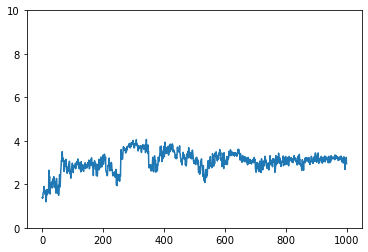

In [26]:
sel = create_selection('protomer','range','monomer')
am_rmsd_1 = calc_rmsd(am_1,am_0,sel)
plt.plot(am_rmsd_1[:,0],am_rmsd_1[:,3])
plt.ylim(0,10)

### All replica RMSD (with mean)

(0.0, 10.0)

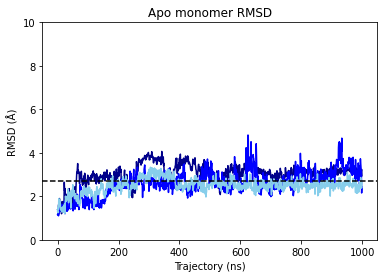

In [27]:
sel = create_selection('protomer','range','monomer')

am_rmsd_1 = calc_rmsd(am_1,am_0,sel)
am_rmsd_2 = calc_rmsd(am_2,am_0,sel)
am_rmsd_3 = calc_rmsd(am_3,am_0,sel)

am_rmsd = [am_rmsd_1[:,3],am_rmsd_2[:,3],am_rmsd_3[:,3]]
am_rmsd_mean = np.mean(am_rmsd)
am_running_mean = get_running_mean(am_rmsd)

plt.plot(am_rmsd_1[:,0],am_rmsd_1[:,3],color='darkblue')
plt.plot(am_rmsd_1[:,0],am_rmsd_2[:,3],color='blue')
plt.plot(am_rmsd_1[:,0],am_rmsd_3[:,3],color='skyblue')

plt.axhline(am_rmsd_mean,color='black',linestyle='dashed')
plt.title('Apo monomer RMSD')
plt.xlabel('Trajectory (ns)')
plt.ylabel('RMSD (Å)')
plt.ylim(0,10)

(0.0, 12.0)

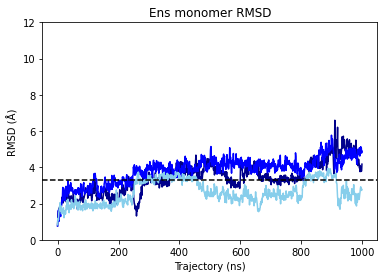

In [28]:
em_rmsd_1 = calc_rmsd(em_1,em_0,sel)
em_rmsd_2 = calc_rmsd(em_2,em_0,sel)
em_rmsd_3 = calc_rmsd(em_3,em_0,sel)

em_rmsd = [em_rmsd_1[:,3],em_rmsd_2[:,3],em_rmsd_3[:,3]]
em_rmsd_mean = np.mean(em_rmsd)
em_running_mean = get_running_mean(em_rmsd)

plt.plot(em_rmsd_1[:,0],em_rmsd_1[:,3],color='darkblue')
plt.plot(em_rmsd_1[:,0],em_rmsd_2[:,3],color='blue')
plt.plot(em_rmsd_1[:,0],em_rmsd_3[:,3],color='skyblue')
plt.axhline(em_rmsd_mean,color='black',linestyle='dashed')
plt.title('Ens monomer RMSD')
plt.xlabel('Trajectory (ns)')
plt.ylabel('RMSD (Å)')
plt.ylim(0,12)

(0.0, 12.0)

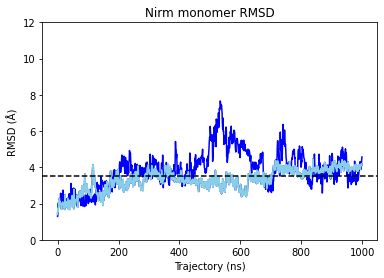

In [29]:
nm_rmsd_1 = calc_rmsd(nm_1,nm_0,sel)
nm_rmsd_2 = calc_rmsd(nm_2,nm_0,sel)
nm_rmsd_3 = calc_rmsd(nm_3,nm_0,sel)

nm_rmsd = [nm_rmsd_1[:,3],nm_rmsd_2[:,3],nm_rmsd_3[:,3]]
nm_rmsd_mean = np.mean(nm_rmsd)
nm_running_mean = get_running_mean(nm_rmsd)

plt.plot(nm_rmsd_1[:,0],nm_rmsd_1[:,3],color='darkblue')
plt.plot(nm_rmsd_1[:,0],nm_rmsd_2[:,3],color='blue')
plt.plot(nm_rmsd_1[:,0],nm_rmsd_3[:,3],color='skyblue')
plt.axhline(nm_rmsd_mean,color='black',linestyle='dashed')
plt.title('Nirm monomer RMSD')
plt.xlabel('Trajectory (ns)')
plt.ylabel('RMSD (Å)')
plt.ylim(0,12)

(0.0, 12.0)

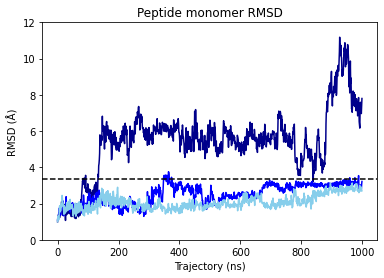

In [30]:
pm_rmsd_1 = calc_rmsd(pm_1,pm_0,sel)
pm_rmsd_2 = calc_rmsd(pm_2,pm_0,sel)
pm_rmsd_3 = calc_rmsd(pm_3,pm_0,sel)

pm_rmsd = [pm_rmsd_1[:,3],pm_rmsd_2[:,3],pm_rmsd_3[:,3]]
pm_rmsd_mean = np.mean(pm_rmsd)
pm_running_mean = get_running_mean(pm_rmsd)

plt.plot(pm_rmsd_1[:,0],pm_rmsd_1[:,3],color='darkblue')
plt.plot(pm_rmsd_1[:,0],pm_rmsd_2[:,3],color='blue')
plt.plot(pm_rmsd_1[:,0],pm_rmsd_3[:,3],color='skyblue')
plt.axhline(pm_rmsd_mean,color='black',linestyle='dashed')
plt.title('Peptide monomer RMSD')
plt.xlabel('Trajectory (ns)')
plt.ylabel('RMSD (Å)')
plt.ylim(0,12)

<BarContainer object of 1 artists>

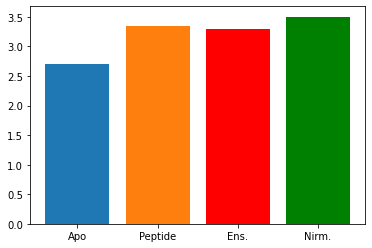

In [31]:
plt.bar('Apo',am_rmsd_mean)
plt.bar('Peptide',pm_rmsd_mean)
plt.bar('Ens.',em_rmsd_mean,color='red')
plt.bar('Nirm.',nm_rmsd_mean,color='green')



## Combined RMSD for all systems (with mean)

## Mean RMSD for all replicates

In [32]:
sel = create_selection('protomer','range','monomer')

am_rmsd_1 = calc_rmsd(am_1,am_0,sel)
am_rmsd_2 = calc_rmsd(am_2,am_0,sel)
am_rmsd_3 = calc_rmsd(am_3,am_0,sel)

nm_rmsd_1 = calc_rmsd(nm_1,nm_0,sel)
nm_rmsd_2 = calc_rmsd(nm_2,nm_0,sel)
nm_rmsd_3 = calc_rmsd(nm_3,nm_0,sel)

em_rmsd_1 = calc_rmsd(em_1,em_0,sel)
em_rmsd_2 = calc_rmsd(em_2,em_0,sel)
em_rmsd_3 = calc_rmsd(em_3,em_0,sel)

pm_rmsd_1 = calc_rmsd(pm_1,pm_0,sel)
pm_rmsd_2 = calc_rmsd(pm_2,pm_0,sel)
pm_rmsd_3 = calc_rmsd(pm_3,pm_0,sel)

am_rmsd = [am_rmsd_1[:,3],am_rmsd_2[:,3],am_rmsd_3[:,3]]
pm_rmsd = [pm_rmsd_1[:,3],pm_rmsd_2[:,3],pm_rmsd_3[:,3]]
nm_rmsd = [nm_rmsd_1[:,3],nm_rmsd_2[:,3],nm_rmsd_3[:,3]] 
em_rmsd = [em_rmsd_1[:,3],em_rmsd_2[:,3],em_rmsd_3[:,3]]

am_rmsd_all = get_running_mean(am_rmsd)
pm_rmsd_all = get_running_mean(pm_rmsd)
nm_rmsd_all = get_running_mean(nm_rmsd)
em_rmsd_all = get_running_mean(em_rmsd)

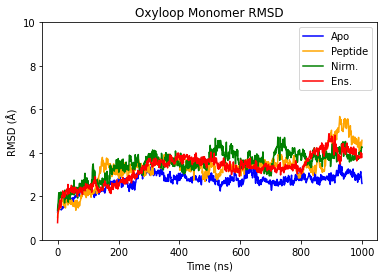

In [33]:
plt.plot(np.arange(0,1000),am_rmsd_all,color='blue',label='Apo')
plt.plot(np.arange(0,1000),pm_rmsd_all,color='orange',label='Peptide')
plt.plot(np.arange(0,1000),nm_rmsd_all,color='green',label='Nirm.')
plt.plot(np.arange(0,1000),em_rmsd_all,color='red',label='Ens.')

plt.ylim(0,10)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (Å)')
plt.title('Oxyloop Monomer RMSD')

plt.savefig('/Users/javingfun/Downloads/RMSD_Oxyloop_Monomer.png', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


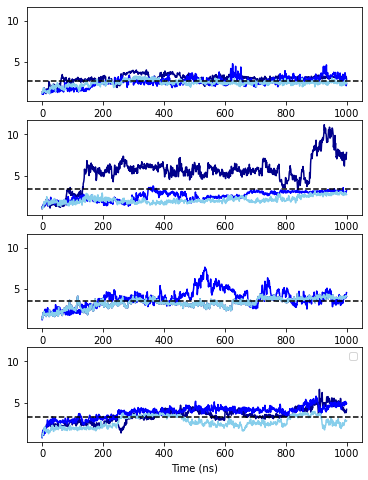

In [34]:
fig, ax = plt.subplots(4,1,figsize=(6,8),sharey=True)
plt.xlabel('Time (ns)',loc='center')


ax[0].plot(am_rmsd_1[:,0],am_rmsd_1[:,3],color='darkblue',label='Replica 1')
ax[0].plot(am_rmsd_1[:,0],am_rmsd_2[:,3],color='blue',label='Replica 2')
ax[0].plot(am_rmsd_1[:,0],am_rmsd_3[:,3],color='skyblue',label='Replica 3')
ax[0].axhline(am_rmsd_mean,color='black',linestyle='dashed')

ax[1].plot(pm_rmsd_1[:,0],pm_rmsd_1[:,3],color='darkblue')
ax[1].plot(pm_rmsd_1[:,0],pm_rmsd_2[:,3],color='blue')
ax[1].plot(pm_rmsd_1[:,0],pm_rmsd_3[:,3],color='skyblue')
ax[1].axhline(pm_rmsd_mean,color='black',linestyle='dashed')

ax[2].plot(nm_rmsd_1[:,0],nm_rmsd_1[:,3],color='darkblue')
ax[2].plot(nm_rmsd_1[:,0],nm_rmsd_2[:,3],color='blue')
ax[2].plot(nm_rmsd_1[:,0],nm_rmsd_3[:,3],color='skyblue')
ax[2].axhline(nm_rmsd_mean,color='black',linestyle='dashed')


ax[3].plot(em_rmsd_1[:,0],em_rmsd_1[:,3],color='darkblue')
ax[3].plot(em_rmsd_1[:,0],em_rmsd_2[:,3],color='blue')
ax[3].plot(em_rmsd_1[:,0],em_rmsd_3[:,3],color='skyblue')
ax[3].axhline(em_rmsd_mean,color='black',linestyle='dashed')

plt.savefig('/Users/javingfun/Downloads/RMSD_Monomer_All.png', dpi=300)
plt.legend()

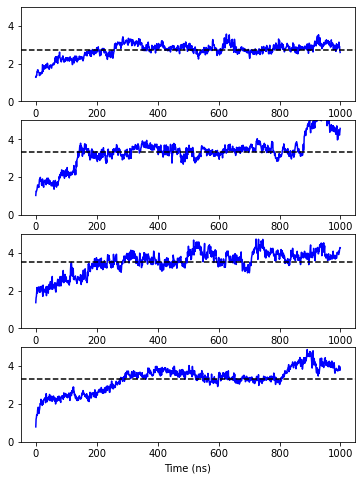

In [35]:
fig, ax = plt.subplots(4,1,figsize=(6,8),sharey=True)
plt.xlabel('Time (ns)',loc='center')
plt.ylim(0,5)

ax[0].plot(am_running_mean,color='blue')
ax[0].axhline(am_rmsd_mean,color='black',linestyle='dashed')


ax[1].plot(pm_running_mean,color='blue')
ax[1].axhline(pm_rmsd_mean,color='black',linestyle='dashed')

ax[2].plot(nm_running_mean,color='blue')
ax[2].axhline(nm_rmsd_mean,color='black',linestyle='dashed')

ax[3].plot(em_running_mean,color='blue')
ax[3].axhline(em_rmsd_mean,color='black',linestyle='dashed')

plt.savefig('/Users/javingfun/Downloads/RMSD_Monomer_RAvg_All.png', dpi=300)

## Dimer RMSD

In [2]:
sel_a = create_selection('protomer','range','monomer')
sel_b = create_selection('protomer','range','dimer')

NameError: name 'create_selection' is not defined

In [60]:
ad_a_rmsd,ad_a_rmsd_mean,ad_a_running_mean = get_rmsd(ad_list,ad_0,sel_a)
ad_b_rmsd,ad_b_rmsd_mean,ad_b_running_mean = get_rmsd(ad_list,ad_0,sel_b)

pd_a_rmsd,pd_a_rmsd_mean,pd_a_running_mean = get_rmsd(pd_list,pd_0,sel_a)
pd_b_rmsd,pd_b_rmsd_mean,pd_b_running_mean = get_rmsd(pd_list,pd_0,sel_b)

nd_a_rmsd,nd_a_rmsd_mean,nd_a_running_mean = get_rmsd(nd_list,nd_0,sel_a)
nd_b_rmsd,nd_b_rmsd_mean,nd_b_running_mean = get_rmsd(nd_list,nd_0,sel_b)

ed_a_rmsd,ed_a_rmsd_mean,ed_a_running_mean = get_rmsd(ed_list,ed_0,sel_a)
ed_b_rmsd,ed_b_rmsd_mean,ed_b_running_mean = get_rmsd(ed_list,ed_0,sel_b)

ad_rmsd_running_mean = get_dimer_running_mean(ad_a_running_mean,ad_b_running_mean)
pd_rmsd_running_mean = get_dimer_running_mean(pd_a_running_mean,pd_b_running_mean)
nd_rmsd_running_mean = get_dimer_running_mean(nd_a_running_mean,nd_b_running_mean)
ed_rmsd_running_mean = get_dimer_running_mean(ed_a_running_mean,ed_b_running_mean)

IndexError: invalid index to scalar variable.

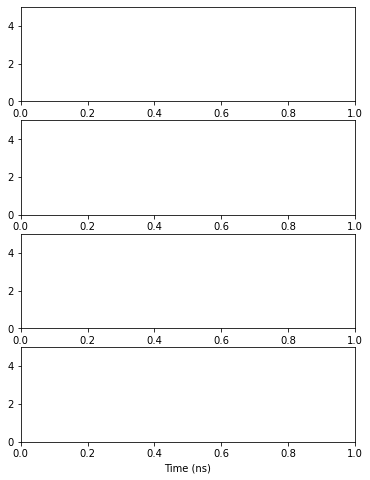

In [61]:
#Plot each replica as the running average of chain A and B
fig, ax = plt.subplots(4,1,figsize=(6,8),sharey=True)
plt.xlabel('Time (ns)',loc='center')
plt.ylim(0,5)



ax[0].plot(ad_a_running_mean[:,3],color='darkblue')
ax[0].plot(ad_b_running_mean[:,3],color='blue')
ax[0].axhline(np.mean(ad_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[1].plot(pd_a_running_mean[:,3],color='darkblue')
ax[1].plot(pd_b_running_mean[:,3],color='blue')
ax[1].axhline(np.mean(pd_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[2].plot(nd_a_running_mean[:,3],color='darkblue')
ax[2].plot(nd_b_running_mean[:,3],color='blue')
ax[2].axhline(np.mean(nd_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[3].plot(ed_a_running_mean[:,3],color='darkblue')
ax[3].plot(ed_b_running_mean[:,3],color='blue')
ax[3].axhline(np.mean(ed_rmsd_running_mean[:,3]),color='black',linestyle='dashed')



plt.savefig('/Users/javingfun/Downloads/RMSD_Dimer_.png', dpi=300)

In [ ]:
plt.plot(ad_rmsd_running_mean[:,3],label='Apo ',color='blue')
plt.plot(pd_rmsd_running_mean[:,3],label='Peptide dimer',color='orange')
plt.plot(nd_rmsd_running_mean[:,3],label='Nirm. dimer',color='green')
plt.plot(ed_rmsd_running_mean[:,3],label='Ens. dimer',color='red')
plt.ylim(0,10)
#plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (Å)')
plt.title('Oxyloop Dimer RMSD')

plt.savefig('/Users/javingfun/Downloads/RMSD_Dimer_Oxyloop.png', dpi=300)

## Asymmetric Dimer RMSD

In [ ]:
sel_a = create_selection('protomer','range','monomer')
sel_b = create_selection('protomer','range','dimer')

In [ ]:
ad_a_rmsd,ad_a_rmsd_mean,ad_a_running_mean = get_rmsd(ad_list,ad_0,sel_a)
ad_b_rmsd,ad_b_rmsd_mean,ad_b_running_mean = get_rmsd(ad_list,ad_0,sel_b)

pa_a_rmsd,pa_a_rmsd_mean,pa_a_running_mean = get_rmsd(pa_list,pa_0,sel_a)
pa_b_rmsd,pa_b_rmsd_mean,pa_b_running_mean = get_rmsd(pa_list,pa_0,sel_b)

na_a_rmsd,na_a_rmsd_mean,na_a_running_mean = get_rmsd(na_list,na_0,sel_a)
na_b_rmsd,na_b_rmsd_mean,na_b_running_mean = get_rmsd(na_list,na_0,sel_b)

ea_a_rmsd,ea_a_rmsd_mean,ea_a_running_mean = get_rmsd(ea_list,ea_0,sel_a)
ea_b_rmsd,ea_b_rmsd_mean,ea_b_running_mean = get_rmsd(ea_list,ea_0,sel_b)

ad_rmsd_running_mean = get_dimer_running_mean(ad_a_running_mean,ad_b_running_mean)
pa_rmsd_running_mean = get_dimer_running_mean(pa_a_running_mean,pa_b_running_mean)
na_rmsd_running_mean = get_dimer_running_mean(na_a_running_mean,na_b_running_mean)
ea_rmsd_running_mean = get_dimer_running_mean(ea_a_running_mean,ea_b_running_mean)

In [ ]:
#Plot each replica as the running average of chain A and B
fig, ax = plt.subplots(4,1,figsize=(6,8),sharey=True)
plt.xlabel('Time (ns)',loc='center')
plt.ylim(0,5)


ax[0].plot(ad_a_running_mean[:,3],color='darkblue')
ax[0].plot(ad_b_running_mean[:,3],color='blue')
ax[0].axhline(np.mean(ad_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[1].plot(pa_a_running_mean[:,3],color='darkblue')
ax[1].plot(pa_b_running_mean[:,3],color='blue')
ax[1].axhline(np.mean(pa_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[2].plot(na_a_running_mean[:,3],color='darkblue')
ax[2].plot(na_b_running_mean[:,3],color='blue')
ax[2].axhline(np.mean(na_rmsd_running_mean[:,3]),color='black',linestyle='dashed')

ax[3].plot(ea_a_running_mean[:,3],color='darkblue')
ax[3].plot(ea_b_running_mean[:,3],color='blue')
ax[3].axhline(np.mean(ea_rmsd_running_mean[:,3]),color='black',linestyle='dashed')



plt.savefig('/Users/javingfun/Downloads/RMSD_Asymm_Dimer_All.png', dpi=300)

In [ ]:
plt.plot(ad_rmsd_running_mean[:,3],label='Apo dimer',color='blue')
plt.plot(pa_rmsd_running_mean[:,3],label='Peptide dimer',color='orange')
plt.plot(na_rmsd_running_mean[:,3],label='Nirm. dimer',color='green')
plt.plot(ea_rmsd_running_mean[:,3],label='Ens. dimer',color='red')
plt.ylim(0,10)
#plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('RMSD (Å)')
plt.title('Oxyloop Half Dimer RMSD')
plt.savefig('/Users/javingfun/Downloads/RMSD_Asymm_Dimer_Oxyloop.png', dpi=300)

## RMSF

## Monomer RMSF

In [ ]:
sel = create_selection('protomer','range','monomer',)
name = 'am'

In [ ]:
am_rmsf_1 = calc_rmsf(am_1,am_0,sel,name)
am_rmsf_2 = calc_rmsf(am_2,am_0,sel,name)
am_rmsf_3 = calc_rmsf(am_3,am_0,sel,name)
am_rmsf =[am_rmsf_1,am_rmsf_2,am_rmsf_3]
am_mean_rmsf = get_mean_rmsf(am_rmsf)

In [ ]:
plt.plot(am_rmsf_1[0],am_rmsf_1[1],color='darkblue')
plt.plot(am_rmsf_2[0],am_rmsf_2[1],color='blue')
plt.plot(am_rmsf_3[0],am_rmsf_3[1],color='skyblue')
plt.axhline(np.average(am_mean_rmsf),color='black',linestyle='--')

In [ ]:
am_rmsf, am_mean_rmsf = get_rmsf(am_list,am_0,sel,'am')
pm_rmsf, pm_mean_rmsf = get_rmsf(pm_list,pm_0,sel,'pm')
nm_rmsf, nm_mean_rmsf = get_rmsf(nm_list,nm_0,sel,'nm')
em_rmsf, em_mean_rmsf = get_rmsf(em_list,em_0,sel,'em')

In [ ]:
fig, ax = plt.subplots(4,1,figsize=(6,8),sharey=True)
plt.xlabel('Residues',loc='center')


ax[0].plot(am_rmsf[0][0],am_rmsf[0][1],color='darkblue')
ax[0].plot(am_rmsf[1][0],am_rmsf[1][1],color='blue')
ax[0].plot(am_rmsf[2][0],am_rmsf[2][1],color='skyblue')
ax[0].plot(am_mean_rmsf,color='black',linestyle='dashed')

ax[1].plot(pm_rmsf[0][0],pm_rmsf[0][1],color='darkblue')
ax[1].plot(pm_rmsf[1][0],pm_rmsf[1][1],color='blue')
ax[1].plot(pm_rmsf[2][0],pm_rmsf[2][1],color='skyblue')
ax[1].plot(pm_mean_rmsf,color='black',linestyle='dashed')

ax[2].plot(nm_rmsf[0][0],nm_rmsf[0][1],color='darkblue')
ax[2].plot(nm_rmsf[1][0],nm_rmsf[1][1],color='blue')
ax[2].plot(nm_rmsf[2][0],nm_rmsf[2][1],color='skyblue')
ax[2].plot(nm_mean_rmsf,color='black',linestyle='dashed')


ax[3].plot(em_rmsf[0][0],em_rmsf[0][1],color='darkblue')
ax[3].plot(em_rmsf[1][0],em_rmsf[1][1],color='blue')
ax[3].plot(em_rmsf[2][0],em_rmsf[2][1],color='skyblue')
ax[3].plot(em_mean_rmsf,color='black',linestyle='dashed')

plt.savefig('/Users/javingfun/Downloads/RMSF_Monomer_Replicas_Interface_1.png', dpi=300)

In [ ]:
am_rmsf[0]

## Dimer RMSF

In [39]:
sel_a = create_selection('protomer','range','monomer')
sel_b = create_selection('protomer','range','dimer')

ad_a_rmsf, ad_a_mean_rmsf = get_rmsf(ad_list,ad_0,sel_a)
ad_b_rmsf, ad_b_mean_rmsf = get_rmsf(ad_list,ad_0,sel_b)
ad_rmsf_running_mean = get_dimer_running_mean(ad_a_mean_rmsf,ad_b_mean_rmsf)

pd_a_rmsf, pd_a_mean_rmsf = get_rmsf(pd_list,pd_0,sel_a)
pd_b_rmsf, pd_b_mean_rmsf = get_rmsf(pd_list,pd_0,sel_b)
pd_rmsf_running_mean = get_dimer_running_mean(pd_a_mean_rmsf,pd_b_mean_rmsf)

nd_a_rmsf, nd_a_mean_rmsf = get_rmsf(nd_list,nd_0,sel_a)
nd_b_rmsf, nd_b_mean_rmsf = get_rmsf(nd_list,nd_0,sel_b)
nd_rmsf_running_mean = get_dimer_running_mean(nd_a_mean_rmsf,nd_b_mean_rmsf)

ed_a_rmsf, ed_a_mean_rmsf = get_rmsf(ed_list,ed_0,sel_a)
ed_b_rmsf, ed_b_mean_rmsf = get_rmsf(ed_list,ed_0,sel_b)
ed_rmsf_running_mean = get_dimer_running_mean(ed_a_mean_rmsf,ed_b_mean_rmsf)

<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 630 atoms>
<Universe with 630 atoms>
<Universe with 630 atoms>
<Universe with 630 atoms>
<Universe with 630 atoms>
<Universe with 630 atoms>
<Universe with 610 atoms>
<Universe with 610 atoms>
<Universe with 610 atoms>
<Universe with 610 atoms>
<Universe with 610 atoms>
<Universe with 610 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>
<Universe with 612 atoms>


In [1]:
#plt.plot(am_mean_rmsf,color='black',linestyle='dashed')
plt.plot(ad_a_mean_rmsf,color='darkblue')
plt.plot(ad_b_mean_rmsf,color='blue')
plt.plot(ad_rmsf_running_mean,color='black',linestyle='dashed')

NameError: name 'plt' is not defined

In [ ]:
x = np.arange(0,306)
len(x)

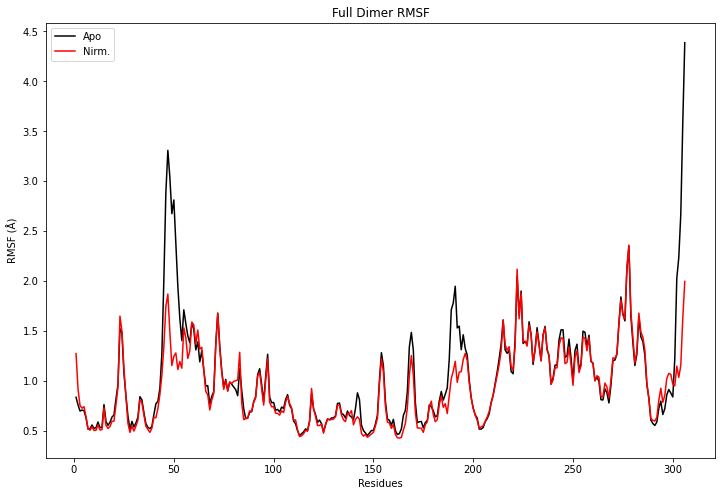

In [43]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(1,307)
plt.plot(x,ad_rmsf_running_mean,color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean,color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean,color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_All.png', dpi=300)

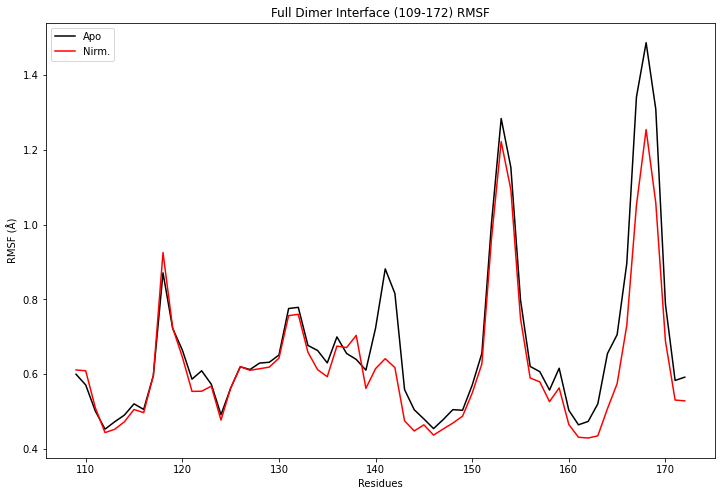

In [44]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(109,173)
plt.plot(x,ad_rmsf_running_mean[109:173],color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean[109:173],color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean[109:173],color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer Interface (109-172) RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_Interface_2.png', dpi=300)

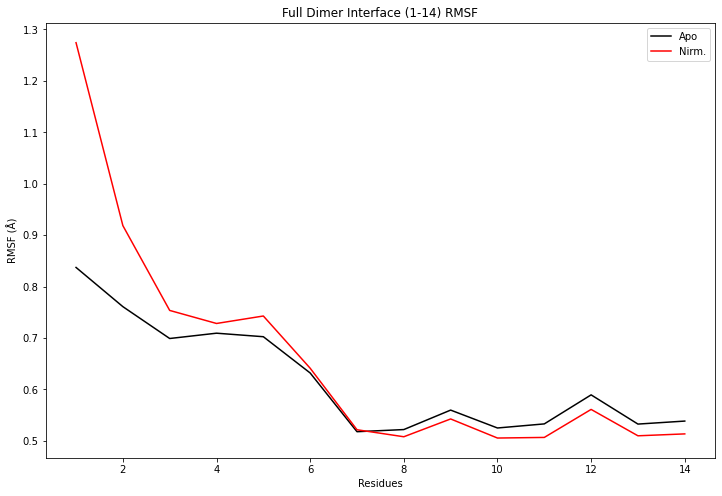

In [58]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(1,15)
plt.plot(x,ad_rmsf_running_mean[0:14],color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean[0:14],color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean[0:14],color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer Interface (1-14) RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_Interface_1.png', dpi=300)

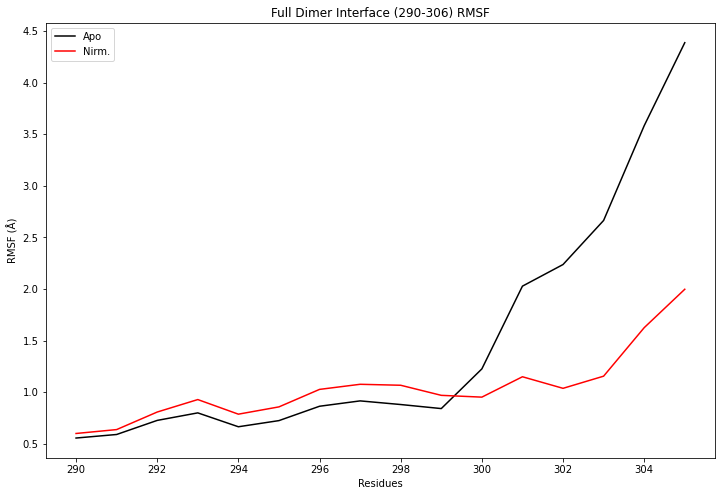

In [57]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(290,306)
plt.plot(x,ad_rmsf_running_mean[290:307],color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean[290:307],color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean[290:307],color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer Interface (290-306) RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_Interface_3.png', dpi=300)

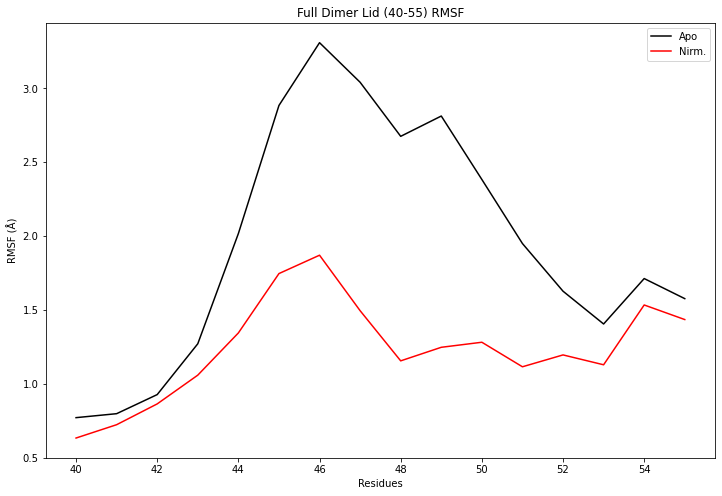

In [46]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(40,56)
plt.plot(x,ad_rmsf_running_mean[40:56],color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean[40:56],color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean[40:56],color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer Lid (40-55) RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_Lid.png', dpi=300)

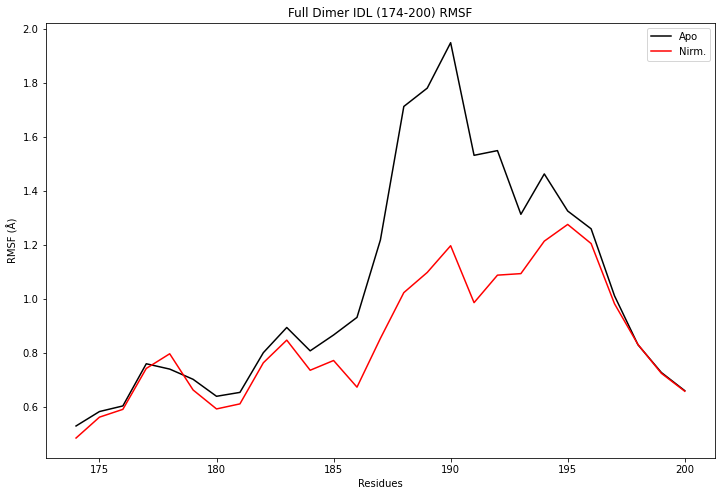

In [47]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(174,201)
plt.plot(x,ad_rmsf_running_mean[174:201],color='black',label='Apo')
#plt.plot(x,pd_rmsf_running_mean[174:201],color='orange',label='Peptide')
plt.plot(x,nd_rmsf_running_mean[174:201],color='red',label='Nirm.')
#plt.plot(x,ed_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Full Dimer IDL (174-200) RMSF')
plt.legend()


plt.savefig('/Users/javingfun/Downloads/RMSF_Dimer_IDL.png', dpi=300)

## Asymmetric Dimer RMSF

In [ ]:
pa_a_rmsf, pa_a_mean_rmsf = get_rmsf(pa_list,pa_0,sel_a)
pa_b_rmsf, pa_b_mean_rmsf = get_rmsf(pa_list,pa_0,sel_b)
pa_rmsf_running_mean = get_dimer_running_mean(pa_a_mean_rmsf,pa_b_mean_rmsf)

na_a_rmsf, na_a_mean_rmsf = get_rmsf(na_list,na_0,sel_a)
na_b_rmsf, na_b_mean_rmsf = get_rmsf(na_list,na_0,sel_b)
na_rmsf_running_mean = get_dimer_running_mean(na_a_mean_rmsf,na_b_mean_rmsf)

ea_a_rmsf, ea_a_mean_rmsf = get_rmsf(ea_list,ea_0,sel_a)
ea_b_rmsf, ea_b_mean_rmsf = get_rmsf(ea_list,ea_0,sel_b)
ea_rmsf_running_mean = get_dimer_running_mean(ea_a_mean_rmsf,ea_b_mean_rmsf)

In [ ]:
fig = plt.subplots(figsize=(12,8))
x = np.arange(109,173)

plt.plot(x,ad_rmsf_running_mean,color='blue',label='Apo')
plt.plot(x,pa_rmsf_running_mean,color='orange',label='Peptide')
plt.plot(x,na_rmsf_running_mean,color='green',label='Nirm.')
plt.plot(x,ea_rmsf_running_mean,color='red',label='Ens.')

plt.xlabel('Residues')
plt.ylabel('RMSF (Å)')
plt.title('Half Dimer RMSF')

plt.savefig('/Users/javingfun/Downloads/RMSF_Asymmetric_Dimer_All.png', dpi=300)

In [ ]:
sel_a = create_selection('protomer','range','monomer')
sel_b = create_selection('protomer','range','dimer')

ad_a_rmsf, ad_a_mean_rmsf = get_rmsf(ad_list,ad_0,sel_a)
ad_b_rmsf, ad_b_mean_rmsf = get_rmsf(ad_list,ad_0,sel_b)
ad_rmsf_running_mean = get_dimer_running_mean(ad_a_mean_rmsf,ad_b_mean_rmsf)

pd_a_rmsf, pd_a_mean_rmsf = get_rmsf(pd_list,pd_0,sel_a)
pd_b_rmsf, pd_b_mean_rmsf = get_rmsf(pd_list,pd_0,sel_b)
pd_rmsf_running_mean = get_dimer_running_mean(pd_a_mean_rmsf,pd_b_mean_rmsf)

nd_a_rmsf, nd_a_mean_rmsf = get_rmsf(nd_list,nd_0,sel_a)
nd_b_rmsf, nd_b_mean_rmsf = get_rmsf(nd_list,nd_0,sel_b)
nd_rmsf_running_mean = get_dimer_running_mean(nd_a_mean_rmsf,nd_b_mean_rmsf)

ed_a_rmsf, ed_a_mean_rmsf = get_rmsf(ed_list,ed_0,sel_a)
ed_b_rmsf, ed_b_mean_rmsf = get_rmsf(ed_list,ed_0,sel_b)
ed_rmsf_running_mean = get_dimer_running_mean(ed_a_mean_rmsf,ed_b_mean_rmsf)

pa_a_rmsf, pa_a_mean_rmsf = get_rmsf(pa_list,pa_0,sel_a)
pa_b_rmsf, pa_b_mean_rmsf = get_rmsf(pa_list,pa_0,sel_b)
pa_rmsf_running_mean = get_dimer_running_mean(pa_a_mean_rmsf,pa_b_mean_rmsf)

na_a_rmsf, na_a_mean_rmsf = get_rmsf(na_list,na_0,sel_a)
na_b_rmsf, na_b_mean_rmsf = get_rmsf(na_list,na_0,sel_b)
na_rmsf_running_mean = get_dimer_running_mean(na_a_mean_rmsf,na_b_mean_rmsf)

ea_a_rmsf, ea_a_mean_rmsf = get_rmsf(ea_list,ea_0,sel_a)
ea_b_rmsf, ea_b_mean_rmsf = get_rmsf(ea_list,ea_0,sel_b)
ea_rmsf_running_mean = get_dimer_running_mean(ea_a_mean_rmsf,ea_b_mean_rmsf)

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(12,8))
x = np.arange(109,173)

ax[0].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[0].plot(x,pd_rmsf_running_mean,color='orange',label='Full Dimer')
ax[0].plot(x,pa_rmsf_running_mean,color='gray',label='Half Dimer')

ax[1].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[1].plot(x,nd_rmsf_running_mean,color='green',label='Full Dimer')
ax[1].plot(x,na_rmsf_running_mean,color='gray',label='Half Dimer')
           
ax[2].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[2].plot(x,ed_rmsf_running_mean,color='red',label='Full Dimer')
ax[2].plot(x,ea_rmsf_running_mean,color='gray',label='Half Dimer')

#plt.savefig('/Users/javingfun/Downloads/RMSF_Interface_2_ByLigand.png', dpi=300)

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(12,8))
x = np.arange(1,15)

ax[0].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[0].plot(x,pd_rmsf_running_mean,color='orange',label='Full Dimer')
ax[0].plot(x,pa_rmsf_running_mean,color='gray',label='Half Dimer')

ax[1].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[1].plot(x,nd_rmsf_running_mean,color='green',label='Full Dimer')
ax[1].plot(x,na_rmsf_running_mean,color='gray',label='Half Dimer')
           
ax[2].plot(x,ad_rmsf_running_mean,color='black',label='Apo')
ax[2].plot(x,ed_rmsf_running_mean,color='red',label='Full Dimer')
ax[2].plot(x,ea_rmsf_running_mean,color='gray',label='Half Dimer')

#plt.savefig('/Users/javingfun/Downloads/RMSF_Interface_1_ByLigand.png', dpi=300)

In [ ]:
ad_povme = mda.Universe('/Users/javingfun/Downloads/apo_dimer_povme_cluster.pdb') 
ad_povme.add_TopologyAttr('tempfactors')

chain_a = ad_povme.select_atoms("resid 1 to 306 and name CA")
chain_b = ad_povme.select_atoms("resid 307 to 612 and name CA")

In [ ]:
chain_a.tempfactors = ad_a_mean_rmsf
chain_b.tempfactors = ad_b_mean_rmsf

In [ ]:
chain_a.write('apo_dimer_bfactor_a_povme.pdb')
chain_b.write('apo_dimer_bfactor_b_povme.pdb')

In [ ]:
print(get_b(selections['ranges']['interface_1'][0]),get_b(selections['ranges']['interface_1'][1]))
print(get_b(selections['ranges']['interface_2'][0]),get_b(selections['ranges']['interface_2'][1]))
print(get_b(selections['ranges']['interface_3'][0]),get_b(selections['ranges']['interface_3'][1]))

In [ ]:
active_site = [182,196]
[get_b(x) for x in active_site]